In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras
# from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [ ]:
df = pd.read_csv('/home/akhil/Downloads/Binance_BTCUSDT_d1.csv', index_col='date')
target_col = 'close'

In [ ]:
def fill_na(df, feature):       # filling null values based on current distribution
    s = df[feature].value_counts(normalize=True)
    missing = df[feature].isnull()
    df.loc[missing,feature] = np.random.choice(s.index, size=len(df[missing]),p=s.values)
fill_na(df, 'tradecount')   # also considering to replace with mean

In [ ]:
df.info()

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

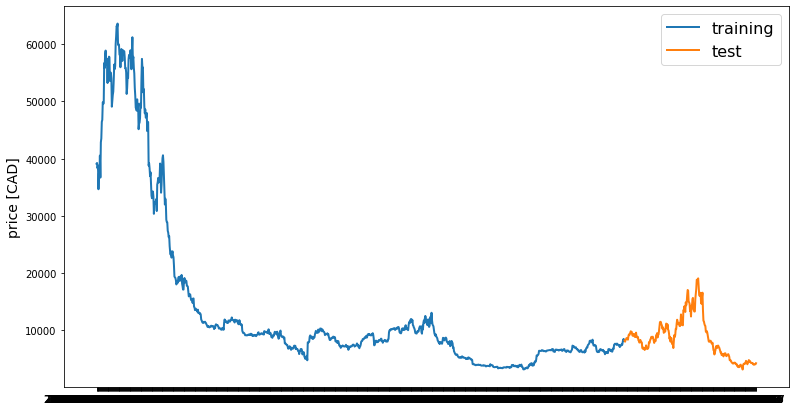

In [6]:
train, test = train_test_split(df, test_size=0.2)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [7]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [9]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
np.random.seed(42)
window_len = 3
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
df.drop(['symbol'],axis=1, inplace=True)

In [11]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [21]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/40
35/35 [==============================] - 2s 7ms/step - loss: 0.0032
Epoch 2/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 3/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 4/40
35/35 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 8.2528e-04
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 8.8113e-04
Epoch 7/40
35/35 [==============================] - 0s 6ms/step - loss: 7.4595e-04
Epoch 8/40
35/35 [==============================] - 0s 8ms/step - loss: 5.2793e-04
Epoch 9/40
35/35 [==============================] - 0s 6ms/step - loss: 2.5484e-04
Epoch 10/40
35/35 [==============================] - 0s 6ms/step - loss: 9.7479e-04
Epoch 11/40
35/35 [==============================] - 0s 7ms/step - loss: 2.0227e-04
Epoch 12/40
35/35 [==============================] - 0s 6ms/step - loss: 1.6231e-04
Epoch 13/40
35/35

In [22]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.007411413467854226

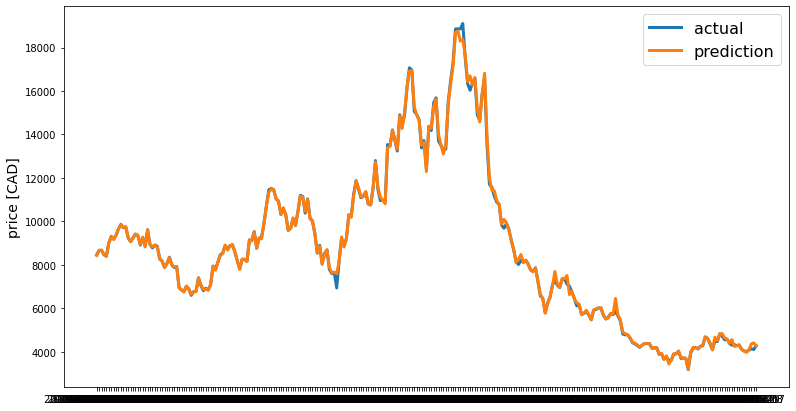

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [12]:
from pmdarima.arima import auto_arima

In [13]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df.close)

(0.4082010552349422, True)

In [17]:
arima_model=auto_arima(df.close, start_p=0, d=0,start_q=0, max_p=5,max_d=0,max_q=5,m=12,seasonal=True,error_action='warn', trace=True, suppress_warnings=True, stepwise=True, random_state=20)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=29056.598, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=30107.510, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=31029.173, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=29455.038, Time=1.61 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=24.85 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=27412.796, Time=18.48 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=7.50 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=18.94 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=22441.522, Time=11.85 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=22439.362, Time=6.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=22437.548, Time=2.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   

In [25]:
predictions = pd.DataFrame(arima_model.predict(n_periods=len(test)), index=test.index)
predictions.columns = ['close']
predictions

,close
date,
2018-05-18 00:00:00,4327.190522
2018-05-17 00:00:00,4337.654660
2018-05-16 00:00:00,4383.400909
2018-05-15 00:00:00,4350.940010
2018-05-14 00:00:00,4383.953625
...,...
2017-08-21,4656.900813
2017-08-20,4655.083569
2017-08-19,4654.357956


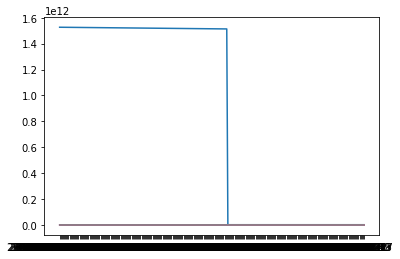

In [27]:
plt.plot(test.c)
plt.pl